In [1]:
import os
from PIL import Image

## Read In Data and Featurization

Parses every age folder in the ./face_age directory, using the PIL library to read in each image. Convert each image into a two demensional array of grayscale pixel value representations. It is then resizes to be a 50 pixel by 50 pixel array, so constrain the number of features. Then we convert to a numpy array and flatten. We then rotate each image by a random degree value between -22 and 22, to add more data to the set and account for different head positions.  

In [27]:
X = []
Y = []
raw_images = []
width = 100
height = 100
INPUT_CLASSES_DIR = 'face_age/'

import numpy as np
import random

for folder_name,_,filenames in os.walk(INPUT_CLASSES_DIR):
    count = 0
    if folder_name !="face_age/":
        if int(folder_name[-3:]) < 70:
            for file in filenames:
                if count < 30:
                    file_path = folder_name +"/"+ file
                    image = Image.open(file_path).convert('L').resize((width, height))
                    X.append(np.array(image).flatten())
                    raw_images.append(image)
                    Y.append(int(folder_name[-3:]))
                    count += 1

                    # add 2 random rotations of the image with a range of -15 to 15 degrees
                    for i in range(2):
                        degrees = random.randint(-22, 22);
                        rotated = image.rotate(degrees)
                        raw_images.append(rotated)
                        X.append(np.array(rotated).flatten())
                        Y.append(int(folder_name[-3:]))


    else:
        pass

Randomly select some raw images to plot

<PIL.Image.Image image mode=L size=100x100 at 0x12F51BAAD70>


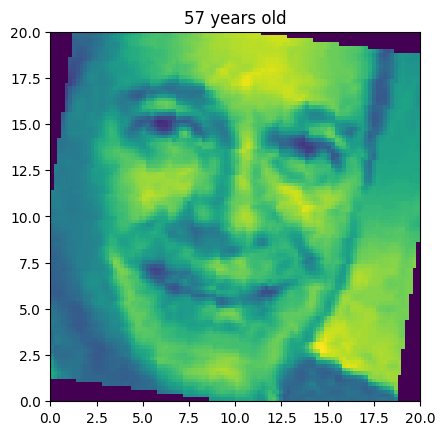

<PIL.Image.Image image mode=L size=100x100 at 0x12F51BA9570>


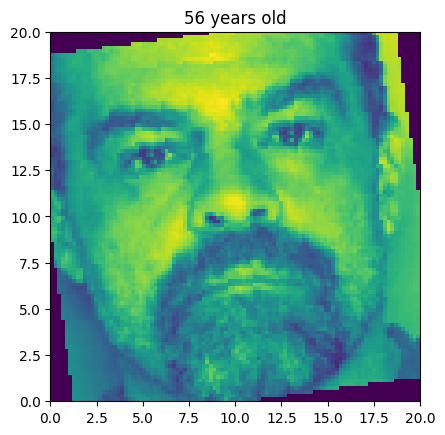

<PIL.Image.Image image mode=L size=100x100 at 0x12F51B80160>


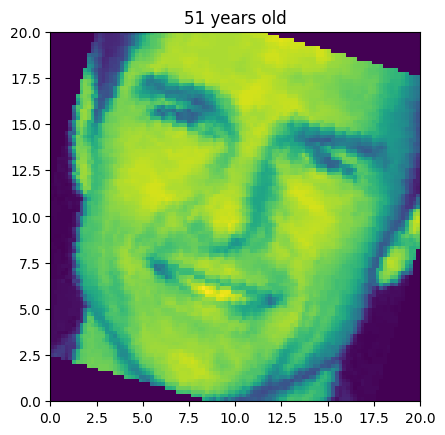

<PIL.Image.Image image mode=L size=100x100 at 0x12F51BA8E80>


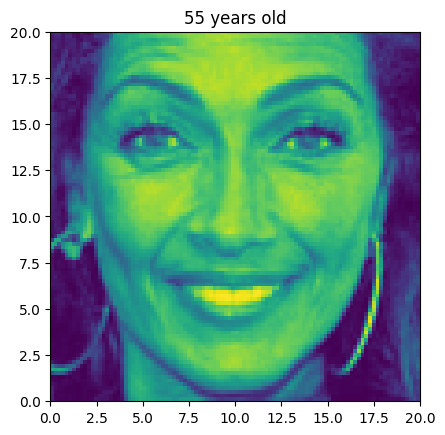

<PIL.Image.Image image mode=L size=100x100 at 0x12F2E165A50>


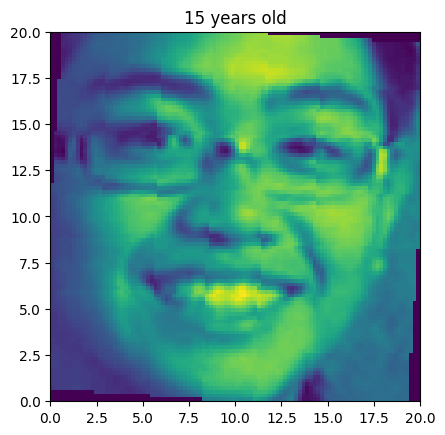

In [28]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(0,5):
    rand = random.randint(0, len(X))
    im = raw_images[rand]
    print(im)
    label = Y[rand]
    fig, ax = plt.subplots()
    im = ax.imshow(im, extent=[0, 20, 0, 20], cmap='gray')
    plt.title(str(label) + " years old")
    plt.show()

#### Convert features and labels into a dataframe

In [29]:
import pandas as pd

df = pd.DataFrame(X)
df['age'] = Y

df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,age
0,112,-125,-119,-119,-117,-117,-116,-114,-114,-111,...,-57,-57,-57,-54,-55,-57,-52,-45,-41,1
1,0,111,-127,-120,-119,-119,-117,-116,-115,-114,...,-58,-58,-53,-50,-51,-46,-44,-47,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-18,-21,-19,-18,-16,-21,-41,-58,-61,-57,...,121,123,123,-125,-115,-104,-96,-97,-95,1
4,0,0,0,0,0,0,-17,-21,-20,-22,...,113,117,-124,0,0,0,0,0,0,1


Print shape of dataframe, showing (rows, columns), where the rows is the number of samples and the columns is number of features + targets.

In [30]:
print(df.shape)

(6198, 10001)


## SVM

Train a Support Vector Machine model with a random subset of the data as the training set. Trained 3 times, on three separate C values (regularization paramter) to see the effect on accuracy. 

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


def plot_effect_of_C(data):

    means = []
    Cs = []

    for d in data:
        means.append(d['our_test_acc'])
        Cs.append(d['C (regularization)'])


    plt.plot(range(len(Cs)),means)
    plt.xticks(range(len(Cs)), Cs)
    plt.title('hyperparameter vs accuracy (within 10 years on either side)')
    plt.xlabel('hyperparameter C')
    plt.ylabel('accuracy')
    plt.show()

def train_test_SVM(features, target):
    data_rows = []
    total_score = 0

    C =  [.8, .9, 1, 1.1, 1.2, 1.3]
    iters = len(C)
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target)

        model = SVC(max_iter=10000, C = C[i], kernel = 'rbf').fit(X_train, y_train)

        # Prediction accuracies and distributions in each age group
        actual = model.predict(X_test)
        expected = y_test.array
        correct = 0

        dictScores = {'0-5': 0, '6-10': 0, '11-15': 0, '16-25': 0, '+25': 0}
        for index, age in enumerate(actual):
            # How well the model perfroms with a 10 year gap
            if abs(age - expected[index]) < 10:
                correct += 1

            diff = abs(age - expected[index])

            if diff <= 5:
                dictScores['0-5']+=1
            elif diff <= 10:
                dictScores['6-10']+=1
            elif diff <= 15:
                dictScores['11-15']+=1
            elif diff <= 25:
                dictScores['16-25']+=1
            else:
                dictScores['+25']+=1


        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        data_rows.append({
            "C (regularization)": C[i],
            "train_acc": train_acc,
            "test_acc": test_acc,
            "our_test_acc": correct/len(X_test)
        })

        print(dictScores)

    plot_effect_of_C(data_rows)
    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)

   

In [33]:
target = df['age']
df2 = df.drop(columns=['age'])
features = df2

{'0-5': 601, '6-10': 205, '11-15': 176, '16-25': 223, '+25': 345}
{'0-5': 637, '6-10': 194, '11-15': 153, '16-25': 233, '+25': 333}
{'0-5': 664, '6-10': 203, '11-15': 152, '16-25': 209, '+25': 322}
{'0-5': 680, '6-10': 189, '11-15': 160, '16-25': 179, '+25': 342}
{'0-5': 727, '6-10': 153, '11-15': 148, '16-25': 201, '+25': 321}
{'0-5': 729, '6-10': 201, '11-15': 142, '16-25': 199, '+25': 279}


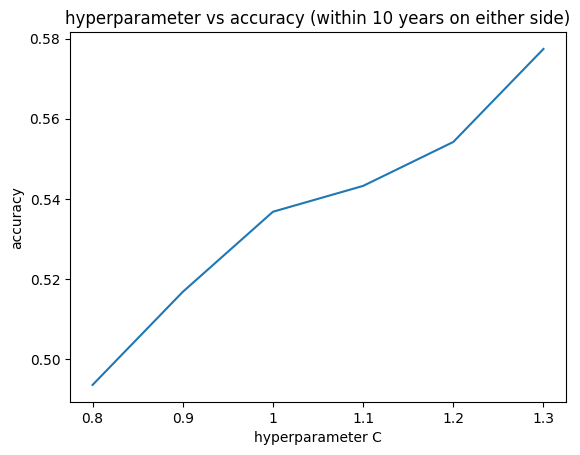

average score 0.2688172043010753 
    C (regularization)  train_acc  test_acc  our_test_acc
0                 0.8   0.745697  0.213548      0.493548
1                 0.9   0.797332  0.228387      0.516774
2                 1.0   0.843158  0.271613      0.536774
3                 1.1   0.879088  0.281290      0.543226
4                 1.2   0.903830  0.305806      0.554194
5                 1.3   0.922762  0.312258      0.577419


In [17]:
train_test_SVM(features, target)

## Logistic Regression

In [36]:

def train_test_logistic_regressor(features, target):

    data_rows = []
    total_score = 0
    iters = 1
    C =  [.8, .9, 1, 1.1, 1.2, 1.3]
    iters = len(C);
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=.6)
        model = LogisticRegression(max_iter=10000, C = C[i]).fit(X_train, y_train)


        # Predict accuracies and distributions in each age group
        actual = model.predict(X_test)
        expected = y_test.array
        correct = 0

        dictScores = { '0-5': 0, '6-10': 0, '11-15': 0, '16-25': 0, '+25': 0}
        for index, age in enumerate(actual):
            # How well the model perfroms with a 10 year gap
            if abs(age - expected[index]) < 10:
                correct += 1

            diff = abs(age - expected[index])

            if diff <= 5:
                dictScores['0-5']+=1
            elif diff <= 10:
                dictScores['6-10']+=1
            elif diff <= 15:
                dictScores['11-15']+=1
            elif diff <= 25:
                dictScores['16-25']+=1
            else:
                dictScores['+25']+=1
                
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        data_rows.append({
            "C (regularization)": C[i],
            "train_acc": train_acc,
            "test_acc": test_acc,
            "our_test_acc": correct/len(X_test)
        })

        print(dictScores)

    plot_effect_of_C(data_rows)
    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)

In [37]:
train_test_logistic_regressor(features, target)

{'0-5': 953, '6-10': 315, '11-15': 245, '16-25': 383, '+25': 584}


In [34]:
X_train, X_test, y_train, y_test = train_test_split(features, target)

model = SVC(max_iter=10000).fit(X_train, y_train)

In [35]:
i = []
file_paths = ["./max.png", "./bill.jpg", './jack.jog', "./holtzen.png"]
raw_images = []
raw_images_predictions = []
for file_name in file_paths:
    image = Image.open(file_name).convert('L').resize((100, 100))
    raw_images.append(image)
    
    i.append(np.array(image).flatten())

    test_df = pd.DataFrame(i)

    raw_images_predictions.append(model.predict([test_df.iloc[0]])[0])


for i in range(len(raw_images)):
    im = raw_images[i]
    label = raw_images_predictions[i]
    fig, ax = plt.subplots()
    im = ax.imshow(im, extent=[0, 20, 0, 20], cmap='gray')
    plt.title("prediction: " + str(label) + " years old")
    plt.show()

    

[56]
None
